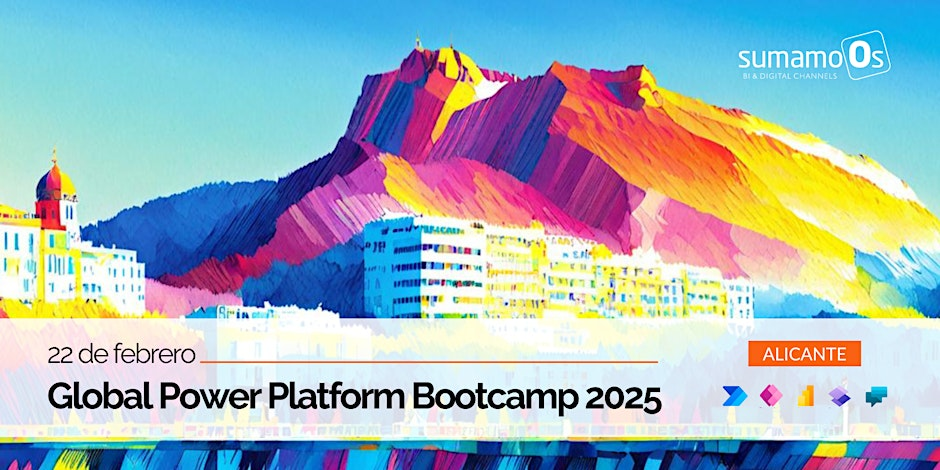

## 1️⃣ **Uso e invocación de API REST**
---

Tal como comentábamos durante la sesión, tenemos disponibles varios métodos dentro de las APIs REST de [Power BI](https://learn.microsoft.com/en-us/rest/api/power-bi/) y [Fabric](https://learn.microsoft.com/en-us/rest/api/fabric/articles/). Gracias a ellas, podemos llevar a cabo diferentes acciones de forma ordenada y a través de diferentes métodos (PowerShell, Python, etc.).

Particularmente, dentro de Fabric, contamos con la librería [semantic-link](https://pypi.org/project/semantic-link/) que nos es especialmente útil a la hora de abordar estos escenarios.

### 🧑‍🏫 Caso de uso

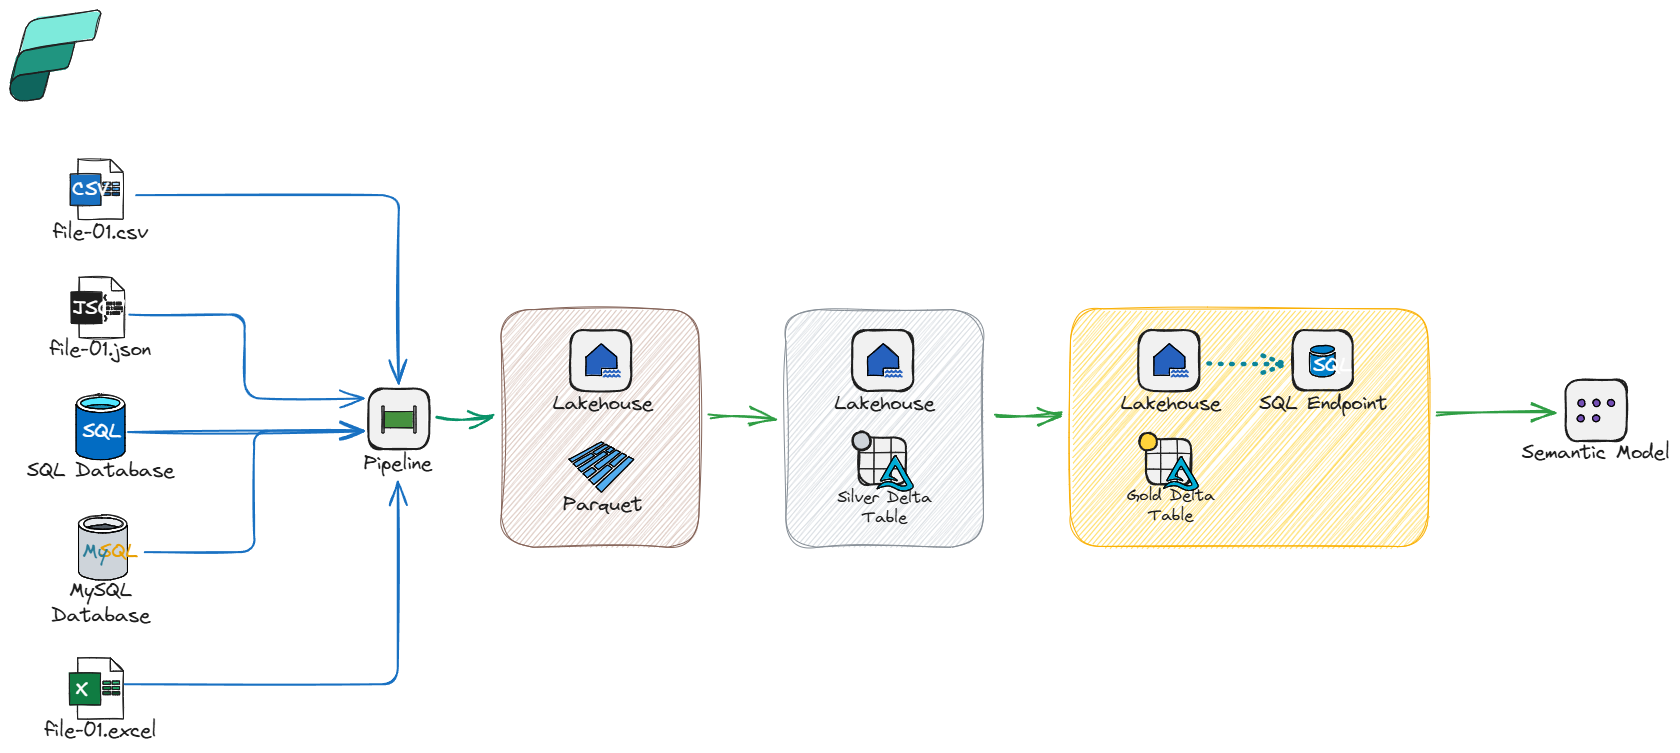

##### 🧩 Parámetros definidos 🧩

In [ ]:
sql_endpoint_id: str = "REPLACE ME"
workspace_id: str = "REPLACE ME"
dataset_id: str = "REPLACE ME"

##### 🔗 Imports y referencias 🔗

In [ ]:
import sempy.fabric as fabric
import time, json, inspect

##### ℹ️ Información y ayuda ℹ️

In [9]:
# Podemos obtener el listado de funciones dentro de sempy
all_members = inspect.getmembers(fabric)
for function_name, member in all_members:
    if inspect.isfunction(member):
        print(function_name)

StatementMeta(, ca1a124e-f2c8-4d1d-b1d5-c2577633c405, 11, Finished, Available, Finished)

__getattr__
_trace_evaluate_dax
create_lakehouse
create_notebook
create_tom_server
create_trace_connection
create_workspace
delete_item
evaluate_dax
evaluate_measure
execute_tmsl
execute_xmla
get_artifact_id
get_lakehouse_id
get_notebook_workspace_id
get_refresh_execution_details
get_roles
get_row_level_security_permissions
get_tmsl
get_workspace_id
list_annotations
list_apps
list_calculation_items
list_capacities
list_columns
list_dataflow_storage_accounts
list_dataflows
list_datasets
list_datasources
list_expressions
list_gateways
list_hierarchies
list_items
list_measures
list_partitions
list_perspectives
list_refresh_requests
list_relationship_violations
list_relationships
list_reports
list_tables
list_translations
list_workspaces
log_telemetry
plot_relationships
read_parquet
read_table
refresh_dataset
refresh_tom_cache
resolve_dataset_id
resolve_dataset_name
resolve_item_id
resolve_item_name
resolve_workspace_id
resolve_workspace_name
run_notebook_job


In [10]:
# También podemos consultar la ayuda para cada una de ellas
# Bastará con invocar el método help pasando como argumento el nombre de la función
# IMPORTANTE: Deberemos invocarla con el alias usado en la importación (fabric en este caso)
help(fabric.get_refresh_execution_details)

StatementMeta(, ca1a124e-f2c8-4d1d-b1d5-c2577633c405, 12, Finished, Available, Finished)

Help on function get_refresh_execution_details in module sempy.fabric._flat:

get_refresh_execution_details(dataset: Union[str, uuid.UUID], refresh_request_id: Union[str, uuid.UUID], workspace: Union[str, uuid.UUID, NoneType] = None) -> sempy.fabric._client._refresh_execution_details.RefreshExecutionDetails
    Poll the status for a specific refresh requests using Enhanced refresh with the Power BI REST API.
    
    More details on the underlying implementation in `PBI Documentation <https://learn.microsoft.com/en-us/power-bi/connect-data/asynchronous-refresh>`_
    
    Parameters
    ----------
    dataset : str or uuid.UUID
        Name or UUID of the dataset.
    refresh_request_id : str or uuid.UUID
        Id of refresh request on which to check the status.
    workspace : str or uuid.UUID, default=None
        The Fabric workspace name or UUID object containing the workspace ID.
        Defaults to None which resolves to the workspace of the attached lakehouse
        or if no 

##### 📄 Funciones definidas 📄

Tenemos un total de tres funciones:
1. La primera de ellas, sirve como wrapper para llevar a cabo llamadas a los métodos del API REST de Fabric
1. Con la segunda, realizamos el refresco del endpoint SQL
1. Y en último lugar, tenemos el refresco del modelo semántico gracias a métodos de sempy

In [ ]:
def fabric_rest_api_caller(
    source_uri: str, method: str, source_payload: str = None
) -> dict:
    """
    Author : Rafael Báguena Girbés  |   02-13-2025

    Function to facilitate making Fabric API calls through the sempy library.

    Receives the desired method for the call, its url and the content to be included if necessary.

    Returns the received response for further use.

    args:   source_uri
            URL of the desired API call

            method
            Method used in the call (post or get)

            source_payload
            Content to be included in the call, may be omitted
    """
    try:
        fabric_client: any = fabric.FabricRestClient()
        match (method):
            case "post":
                if source_payload:
                    response = fabric_client.post(source_uri, json=source_payload)
                else:
                    response = fabric_client.post(source_uri)
            case "get":
                response = fabric_client.get(source_uri)
            case _:
                raise NotImplementedError
        return response
    except NotImplementedError:
        print("*ERROR*: ❌ Specified method is not implemented.")
    except Exception as err:
        print(f"*ERROR*: ❌ Something went wrong, the error ocurred is: {err=}")

def sql_endpoint_refresh(sql_endpoint_id: str) -> None:
    """
    Author : Rafael Báguena Girbés  |   02-13-2025

    Function that enables refreshing of the received SQL endpoint via API call.

    No need to specify the workspace.

    Once the refresh request is triggered, its status is checked every 30 seconds to ensure that it is complete.

    args:   sql_endpoint_id
            Identifier of the SQL endpoint to be refreshed
    """
    call_uri: str = f"/v1.0/myorg/lhdatamarts/{sql_endpoint_id}"
    payload: dict = {"commands": [{"$type": "MetadataRefreshCommand"}]}

    try:
        print(f"*INFO*: ▶️ Starting refresh for '{sql_endpoint_id}' SQL Endpoint.")

        refresh_response = fabric_rest_api_caller(call_uri, "post", payload)
        batch_id_value: str = refresh_response.json()["batchId"]
        progress_status: str = refresh_response.json()["progressState"]

        status_uri: str = (
            f"/v1.0/myorg/lhdatamarts/{sql_endpoint_id}/batches/{batch_id_value}"
        )
        while progress_status == "inProgress":
            print(f"*INFO*: 🔎 Checking status for '{batch_id_value}' batch.")
            status_response = fabric_rest_api_caller(status_uri, "get")
            progress_status: str = status_response.json()["progressState"]
            print(f"*INFO*: ⚠️ Current status is '{progress_status}'.")
            if progress_status == "success":
                break
            else:
                print("*INFO*: ⌛ Checking again in 30 seconds.")
                time.sleep(30)

        print(f"*INFO*: ✅ SQL Endpoint '{sql_endpoint_id}' successfully refreshed.")
    except Exception as err:
        print(f"*ERROR*: ❌ Something went wrong, the error ocurred is: {err=}")

def semantic_model_refresh(workspace_id: str, dataset_id: str) -> None:
    """
    Author : Rafael Báguena Girbés  |   02-13-2025

    This function executes the refresh of the specified semantic model thanks to the existing sempy functions refresh_dataset and get_refresh_execution_details.

    Once the refresh request is triggered, its status is checked every 30 seconds to ensure that it is complete.

    args:   workspace_id
            Identifier of the workspace where the semantic model resides

            dataset_id
            Identifier of the semantic model to be refreshed
    """
    try:
        print(f"*INFO*: ▶️ Starting refresh for '{dataset_id}' semantic model.")

        refresh_request_id = fabric.refresh_dataset(
            dataset=dataset_id, workspace=workspace_id
        )

        refresh_status: str = "Not started"
        while refresh_status not in {"Completed", "Failed"}:
            refresh_details = fabric.get_refresh_execution_details(
                dataset=dataset_id,
                refresh_request_id=refresh_request_id,
                workspace=workspace_id,
            )
            refresh_status = refresh_details.status
            print(f"*INFO*: ⚠️ Current status is '{refresh_status}'.")
            match (refresh_status):
                case "Completed":
                    break
                case "Failed":
                    raise Exception("The refresh has failed.")
                case _:
                    print("*INFO*: ⌛ Checking again in 30 seconds.")
                    time.sleep(30)

        print(f"*INFO*: ✅ Semantic model '{dataset_id}' successfully refreshed.")
    except Exception as err:
        print(f"*ERROR*: ❌ Something went wrong, the error ocurred is: {err=}")

##### 🪄 Que empiece la magia 🪄

In [12]:
# Llamada ordenada a las funciones
sql_endpoint_refresh(sql_endpoint_id)
semantic_model_refresh(workspace_id, dataset_id)

StatementMeta(, ca1a124e-f2c8-4d1d-b1d5-c2577633c405, 14, Finished, Available, Finished)

*INFO*: ▶️ Starting refresh for '994c13ed-d645-4fa0-bbda-fda343871509' SQL Endpoint.
*INFO*: 🔎 Checking status for '994c13ed-d645-4fa0-bbda-fda343871509@f842b6a9-f5ee-45b9-b486-25a555f46825$2025-03-05T19:08:01.7593412Z@73027d91-3fb8-49b3-9f56-e72074a0a710' batch.
*INFO*: ⚠️ Current status is 'inProgress'.
*INFO*: ⌛ Checking again in 30 seconds.
*INFO*: 🔎 Checking status for '994c13ed-d645-4fa0-bbda-fda343871509@f842b6a9-f5ee-45b9-b486-25a555f46825$2025-03-05T19:08:01.7593412Z@73027d91-3fb8-49b3-9f56-e72074a0a710' batch.
*INFO*: ⚠️ Current status is 'success'.
*INFO*: ✅ SQL Endpoint '994c13ed-d645-4fa0-bbda-fda343871509' successfully refreshed.
*INFO*: ▶️ Starting refresh for 'c6563122-403f-43f4-a8be-1f6534372c7c' semantic model.
*INFO*: ⚠️ Current status is 'Unknown'.
*INFO*: ⌛ Checking again in 30 seconds.
*INFO*: ⚠️ Current status is 'Completed'.
*INFO*: ✅ Semantic model 'c6563122-403f-43f4-a8be-1f6534372c7c' successfully refreshed.
